# PyMC Webinar - Live Demo (PyMC-Marketing 2023 Recap)
Example notebook showing different uses of PyMC-Marketing with a few relevant releases during the 2023.

# Install Libraries

In [ ]:
# %pip install --upgrade pip
# %pip install --upgrade pymc-marketing pymc arviz
# %pip install https://github.com/pymc-labs/pymc-marketing.git

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
from pymc_marketing.mmm import DelayedSaturatedMMM

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Dec 21 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

pytensor: 2.18.1

numpy     : 1.23.5
pandas    : 1.5.3
pymc      : 5.10.2
arviz     : 0.16.1
matplotlib: 3.7.0
seaborn   : 0.12.2

Watermark: 2.4.3



# Read DataFrame

In [3]:
df = pd.read_csv("demo.csv", index_col="Unnamed: 0")

In [4]:
# Assuming your DataFrame is named df
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      61 non-null     datetime64[ns]
 1   y       61 non-null     float64       
 2   meta    61 non-null     float64       
 3   google  61 non-null     float64       
 4   ooh     61 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.9 KB


# Introduction: How to use PyMC-Marketing?

In [5]:
# Instantiate the DelayedSaturatedMMM model
mmm = DelayedSaturatedMMM(
    date_column="ds",
    channel_columns=["meta", "google", "ooh"],
    adstock_max_lag=8,   # Adjust this value based on your domain knowledge
    yearly_seasonality=2 # This is for capturing yearly seasonality patterns
)

In [6]:
# Split the data into predictors (X) and the target variable (y)
X = df.drop('y', axis=1)
y = df['y']

# Fit the model
mmm.fit(X, y,
#     target_accept=0.97,
#     chains=4,
#     draws=2000,
#     tune=2000,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_fourier, likelihood_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

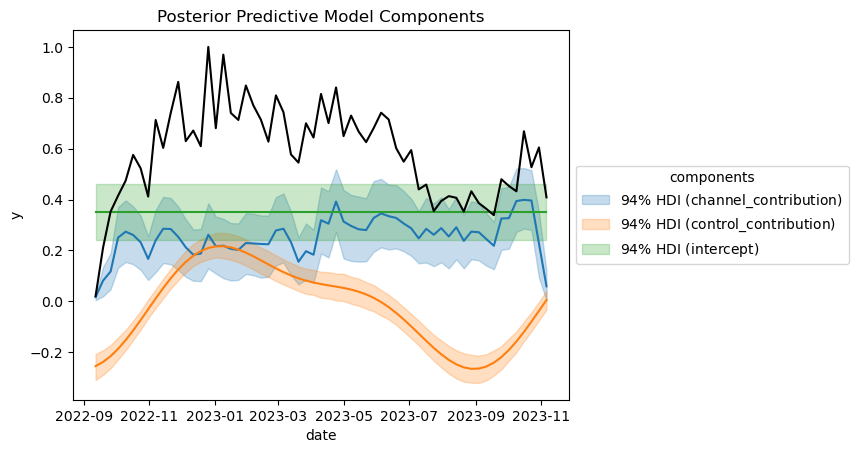

In [7]:
components_fig = mmm.plot_components_contributions()

In [8]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

,meta,google,ooh,sin_order_1,cos_order_1,sin_order_2,cos_order_2,intercept
date,,,,,,,,
2022-09-12,0.000000,17.340870,0.000000,-135.648633,-52.012662,-30.591776,-50.847750,371.712766
2022-09-19,0.000000,85.567738,0.000000,-140.170890,-33.139977,-20.141426,-58.629421,371.712766
2022-09-26,6.348371,112.261044,4.671774,-142.663089,-13.787334,-8.528489,-63.026933,371.712766
2022-10-03,17.416760,222.573107,23.917443,-143.089137,5.764987,3.576722,-63.786456,371.712766
2022-10-10,24.450579,235.841444,28.239060,-141.442863,25.233815,15.475481,-60.864149,371.712766


# New Feature | Change prior distributions: Customize your model

In [9]:
# Instantiate a dummy model to see the default configuration
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=1)
dummy_model.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}}

In [10]:
custom_beta_channel_prior = {'intercept': {'dist': 'LogNormal',
                                              "kwargs":{"mu":1, "sigma": 2},
                                },
                             'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': [2,3,4]}}
                            }
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}
my_model_config

{'intercept': {'dist': 'LogNormal', 'kwargs': {'mu': 1, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}}

In [11]:
# Instantiate the DelayedSaturatedMMM model
mmm = DelayedSaturatedMMM(
    model_config=my_model_config,
    date_column="ds",
    channel_columns=["meta", "google", "ooh"],
    adstock_max_lag=8,   # Adjust this value based on your domain knowledge
    yearly_seasonality=2 # This is for capturing yearly seasonality patterns
)

# Fit the model
mmm.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_fourier, likelihood_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [13]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.347,0.059,0.238,0.457,0.002,0.001,1264.0,1348.0,1.0
likelihood_sigma,0.078,0.008,0.063,0.093,0.000,0.000,2391.0,2291.0,1.0
beta_channel[meta],0.180,0.216,0.000,0.452,0.005,0.004,1764.0,1247.0,1.0
beta_channel[google],0.339,0.073,0.211,0.462,0.002,0.002,1639.0,1395.0,1.0
beta_channel[ooh],0.087,0.126,0.000,0.249,0.003,0.003,1625.0,1661.0,1.0
alpha[meta],0.213,0.168,0.000,0.522,0.002,0.002,3824.0,1633.0,1.0
alpha[google],0.111,0.081,0.000,0.253,0.001,0.001,2069.0,1188.0,1.0
alpha[ooh],0.242,0.187,0.000,0.588,0.002,0.002,5147.0,2479.0,1.0
lam[meta],2.435,1.656,0.120,5.451,0.028,0.019,2931.0,2196.0,1.0
lam[google],6.824,1.982,3.055,10.583,0.058,0.041,1278.0,791.0,1.0


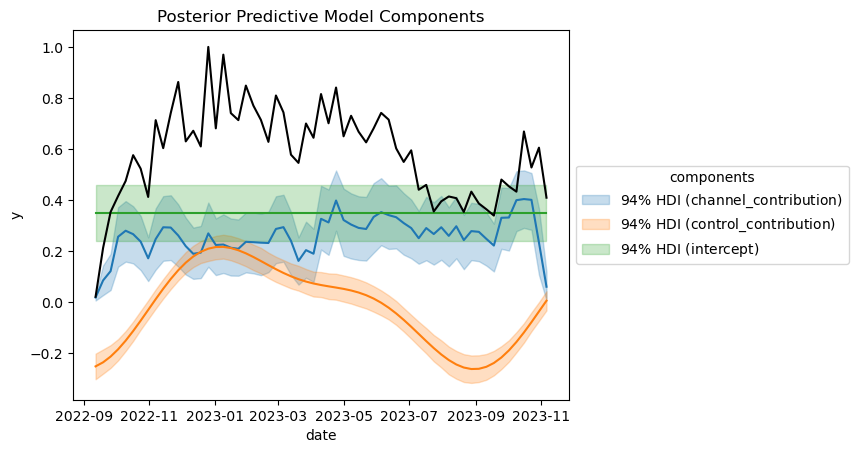

In [14]:
components_fig = mmm.plot_components_contributions()

# New Feature | Response Curves Fit

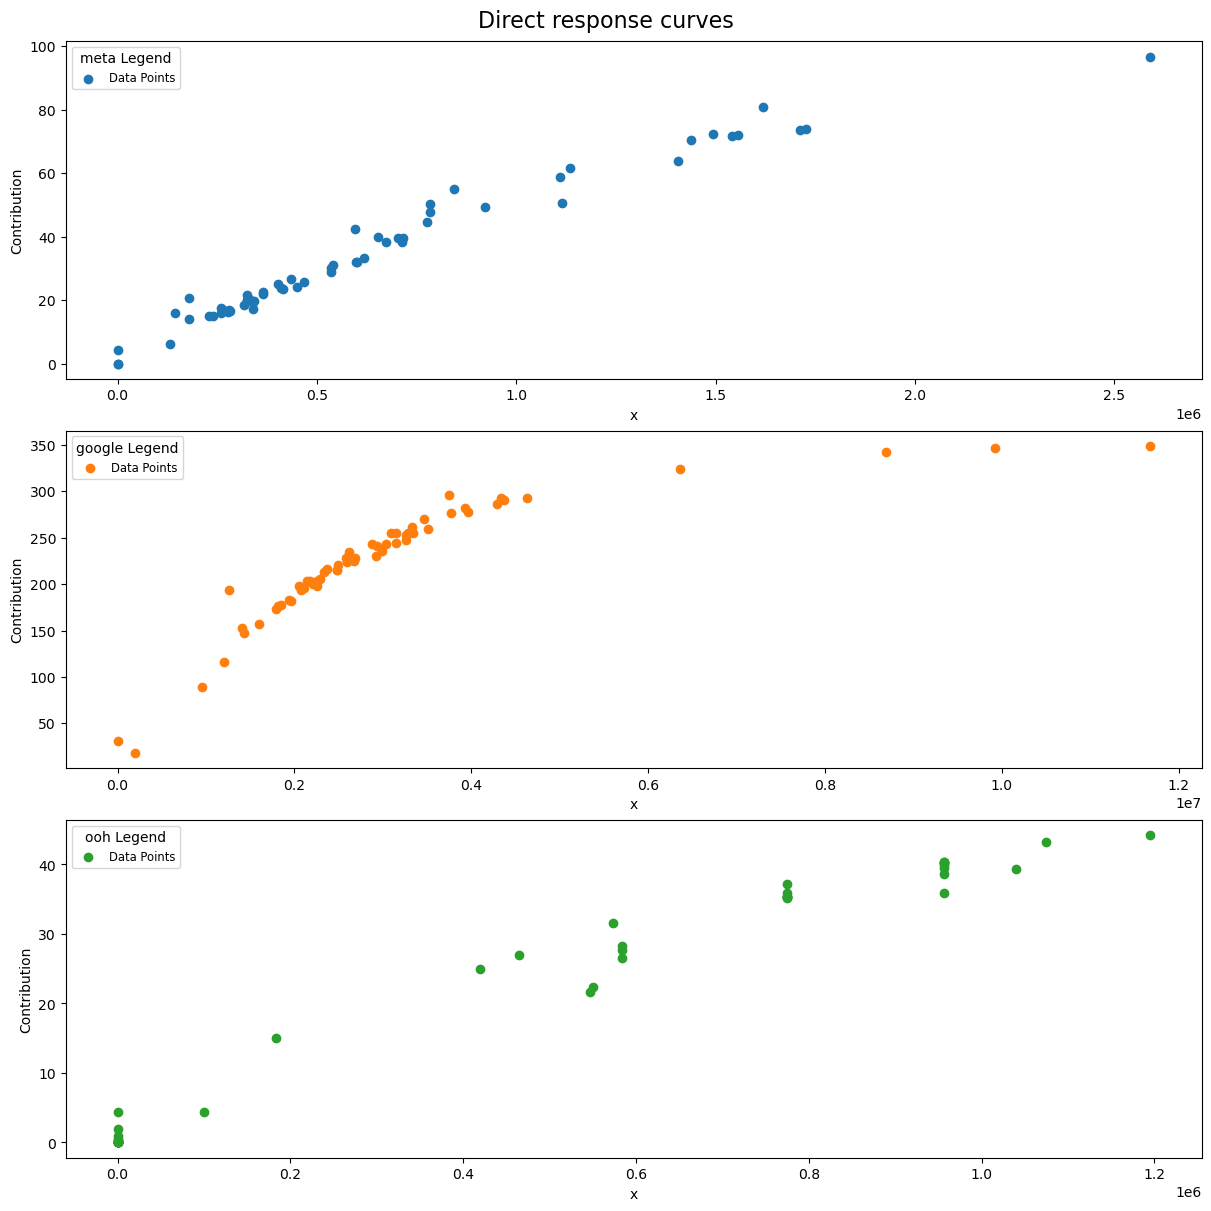

In [15]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

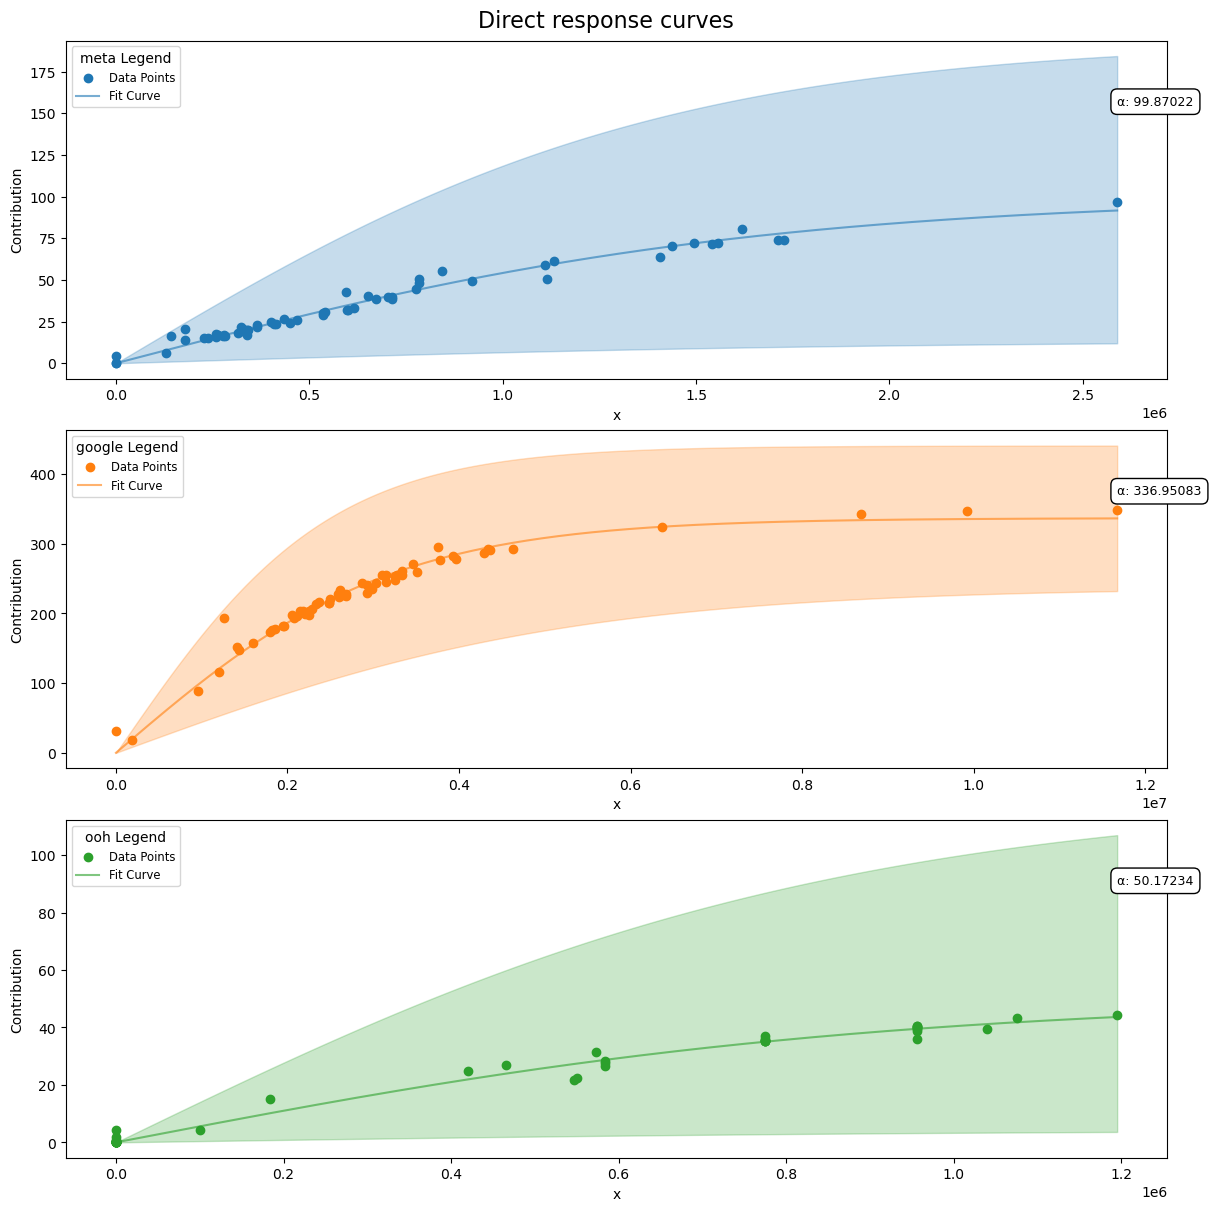

In [16]:
fig = mmm.plot_direct_contribution_curves(show_fit=True)
[ax.set(xlabel="x") for ax in fig.axes];

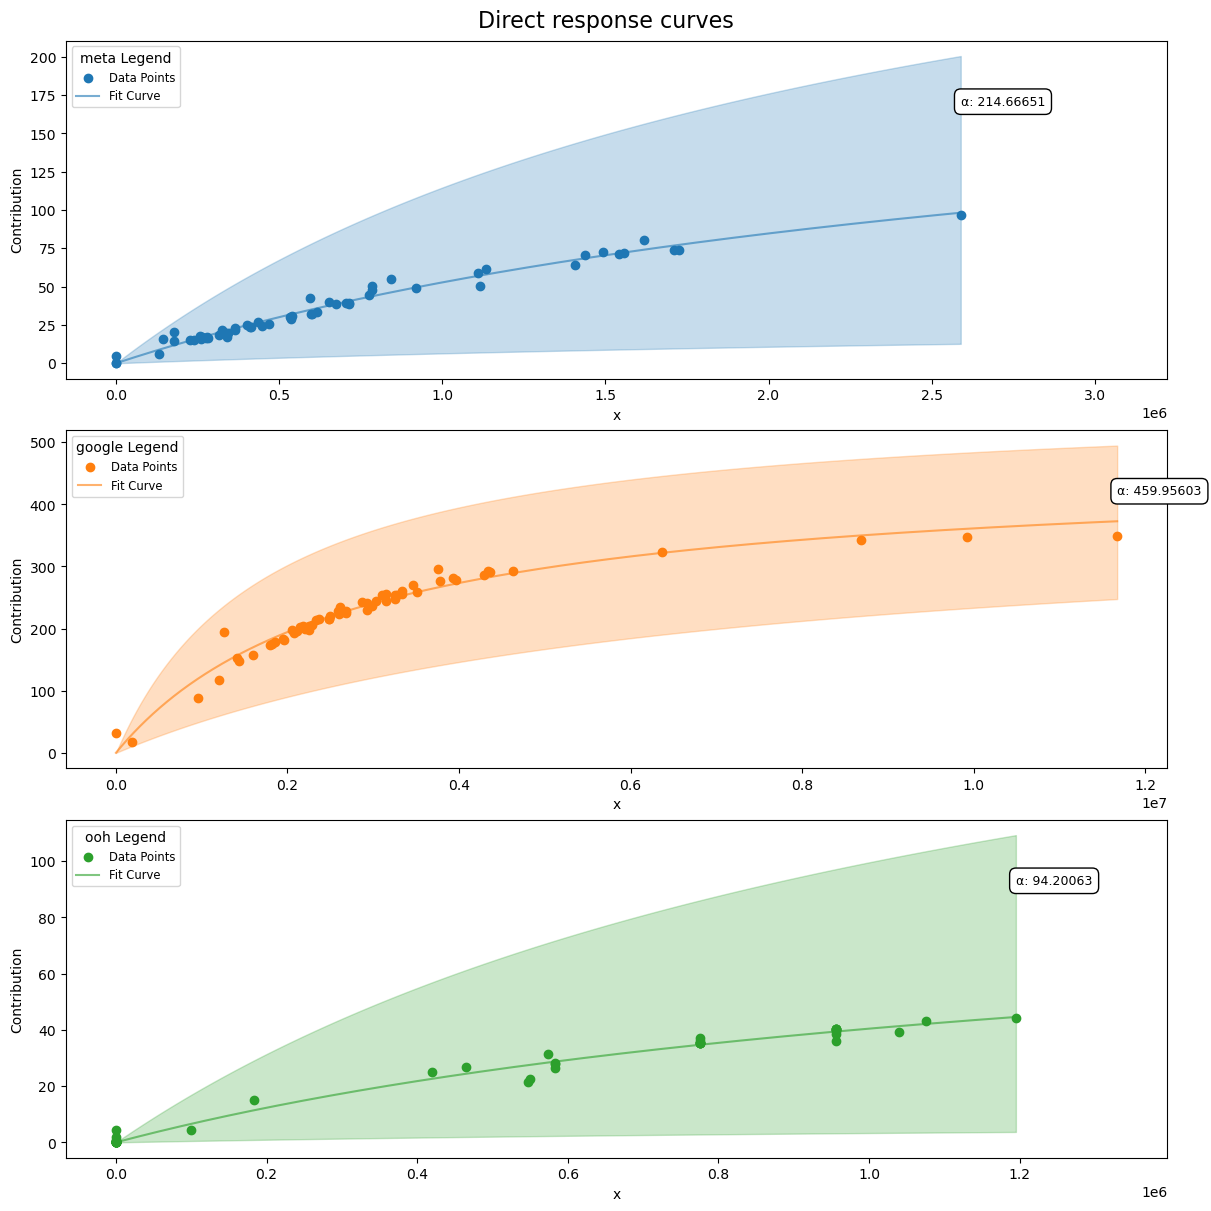

In [17]:
fig = mmm.plot_direct_contribution_curves(show_fit=True, method="michaelis-menten")
[ax.set(xlabel="x") for ax in fig.axes];

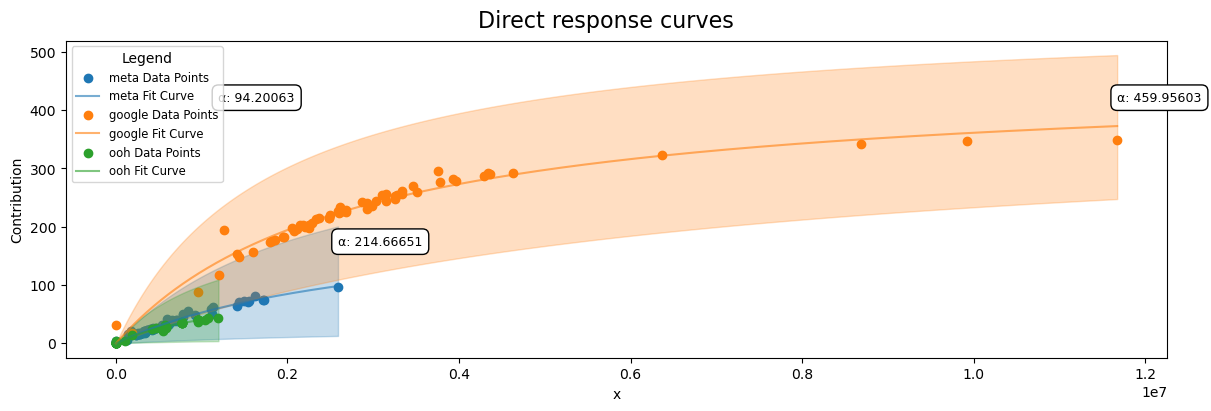

In [18]:
fig = mmm.plot_direct_contribution_curves(show_fit=True, method="michaelis-menten", same_axes=True)
[ax.set(xlabel="x") for ax in fig.axes];

# Use Case 1: Time Based budget allocation

In [19]:
from pymc_marketing.mmm.utils import (
    estimate_menten_parameters,
    michaelis_menten,
)

In [20]:
michaelis_menten?

In [21]:
#python
menten_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='michaelis-menten')
menten_params                        

/opt/homebrew/anaconda3/lib/python3.10/site-packages/pymc_marketing/mmm/base.py:920: UserWarning: The curve optimization parameters method is experimental
  warnings.warn(


{'meta': array([2.14666509e+02, 3.06860189e+06]),
 'google': array([4.59956034e+02, 2.73080267e+06]),
 'ooh': array([9.42006264e+01, 1.32950034e+06])}

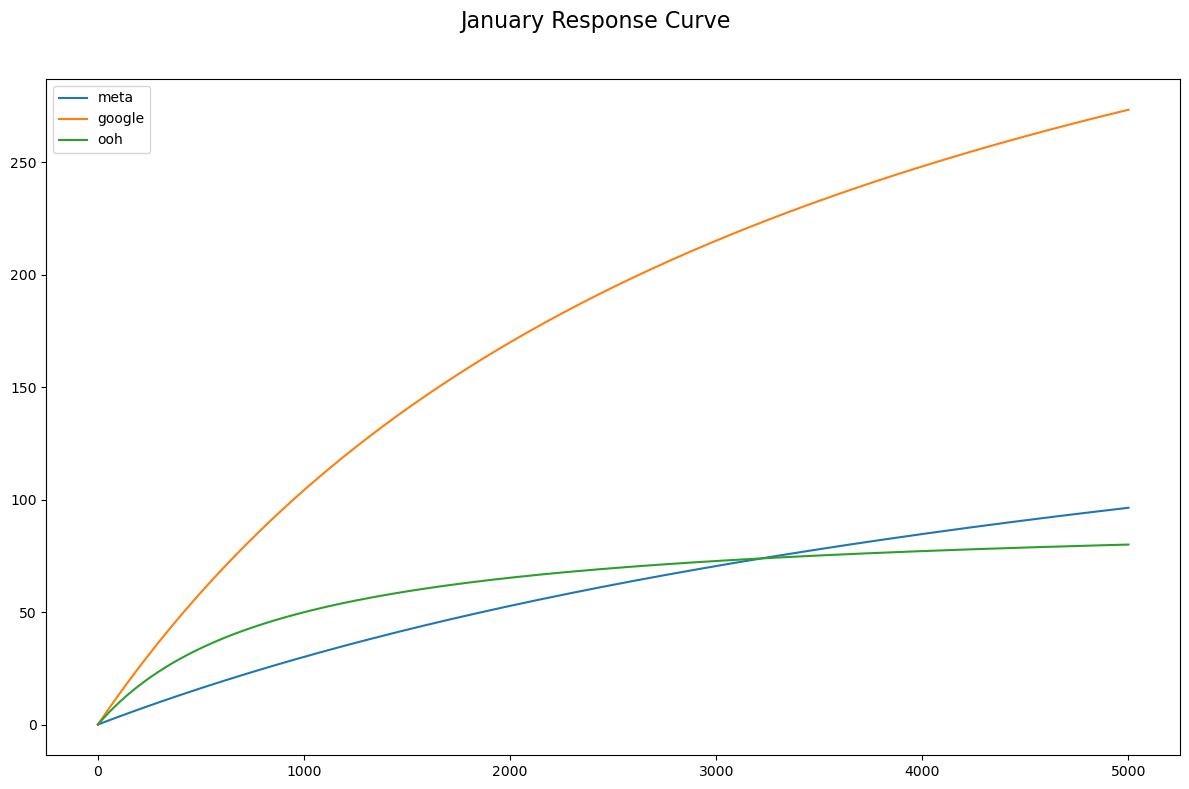

In [22]:
#January
impressions_per_euro = {
    'meta': 500,
    'google': 800,
    'ooh': 1500
}

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, 8),
)
    
x = np.linspace(0, 5000, 10000)

for i, channel in enumerate(menten_params.keys()):
    y = michaelis_menten(x = x, alpha = menten_params[channel][0], 
                            lam = menten_params[channel][1] / impressions_per_euro[channel])

    ax.plot(x, y, color=f"C{i}", linestyle='-', label=channel)

fig.suptitle("January Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  #Adjust the layout to make room for the suptitle
plt.legend()
plt.show()  

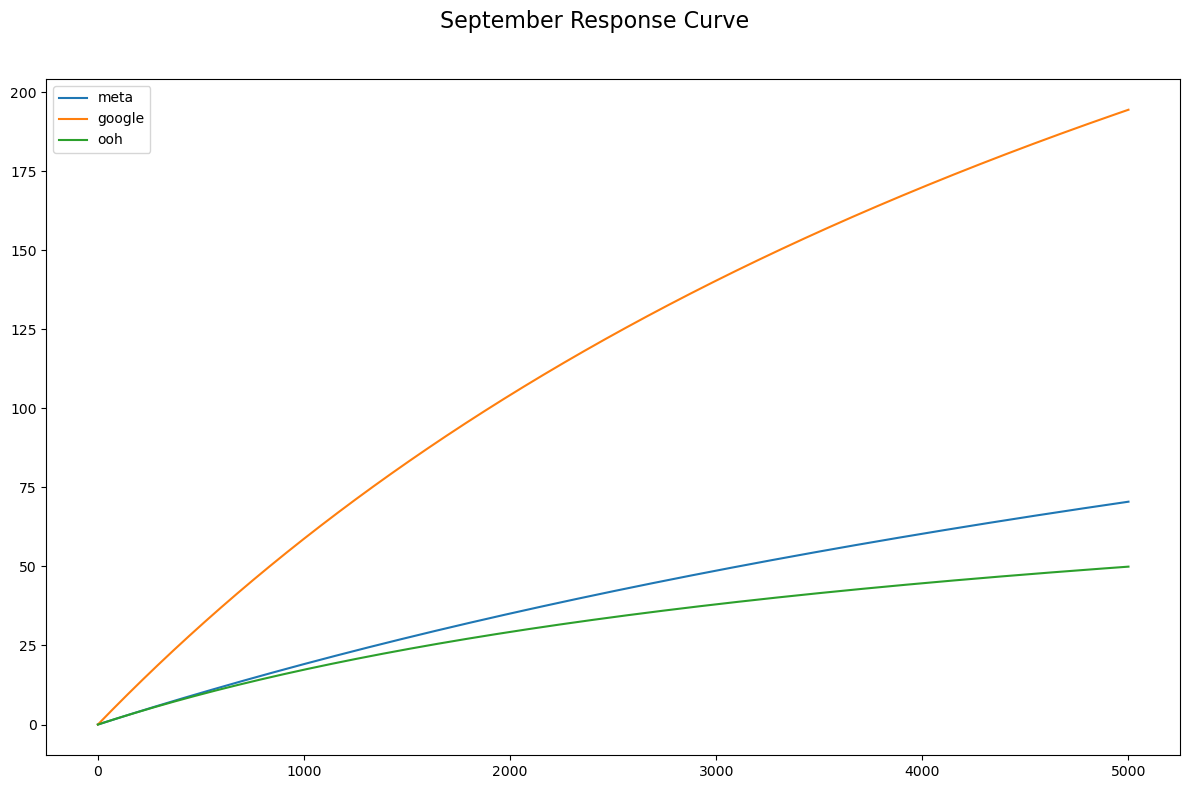

In [23]:
#September
impressions_per_euro = {
    'meta': 300,
    'google': 400,
    'ooh': 300
}

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, 8),
)
    
x = np.linspace(0, 5000, 10000)

for i, channel in enumerate(menten_params.keys()):
    y = michaelis_menten(x = x, alpha = menten_params[channel][0], 
                            lam = menten_params[channel][1] / impressions_per_euro[channel])

    ax.plot(x, y, color=f"C{i}", linestyle='-', label=channel)

fig.suptitle("September Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the layout to make room for the suptitle
plt.legend()
plt.show()  

In [24]:
# Modified dictionary
menten_params_modified = {
    key: [value[0], value[1] / impressions_per_euro[key]] 
    for key, value in menten_params.items()
}

# menten_params_april = {key: [value[0], value[1] / april_ipe[key]] for key, value in menten_params.items()}
# menten_params_may = {key: [value[0], value[1] / may_ipe[key]] for key, value in menten_params.items()}         
                            
menten_params_modified

{'meta': [214.66650925074748, 10228.672974301575],
 'google': [459.9560341656939, 6827.00666284715],
 'ooh': [94.2006263788242, 4431.667795814518]}

In [25]:
from pymc_marketing.mmm.budget_optimizer import (
    budget_allocator,
    calculate_expected_contribution
)

In [26]:
#python
total_budget = 15000
#Define your channels
channels = list(menten_params.keys())
#The initial split per channel
budget_per_channel = total_budget / len(channels)
#Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}

initial_contribution = calculate_expected_contribution(
    method='michaelis-menten',
    parameters = menten_params_modified,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict,
}

pd.DataFrame(initial_scenario)

,initial_contribution,initial_budget
meta,70.481029,5000.0
google,194.451583,5000.0
ooh,49.938478,5000.0
total,314.871090,NaN


In [27]:
budget_bounds =  {
  'meta': [200, menten_params_modified["meta"][1] * 8],
  'google': [200, menten_params_modified["google"][1] * 8],
  'ooh': [0, menten_params_modified["ooh"][1] * 8],
}

result_menten = budget_allocator(
            method='michaelis-menten',
            total_budget=total_budget,
            channels=channels,
            parameters=menten_params_modified,
            budget_ranges=budget_bounds,
        )

result_menten

,estimated_contribution,optimal_budget
meta,57.566731,3748.135549
google,269.823749,9688.457310
ooh,24.565820,1563.407140
total,351.956300,15000.000000


# Use Case 2: Allocate budget based on CLV
- [PyMC CLV Models](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_example.html)

In [28]:
avg_ltv_per_user = 20
menten_params_modified_ltv = {
    key: [value[0] * avg_ltv_per_user, value[1] / impressions_per_euro[key]] 
    for key, value in menten_params.items()
}
menten_params_modified_ltv

{'meta': [4293.330185014949, 10228.672974301575],
 'google': [9199.120683313879, 6827.00666284715],
 'ooh': [1884.012527576484, 4431.667795814518]}

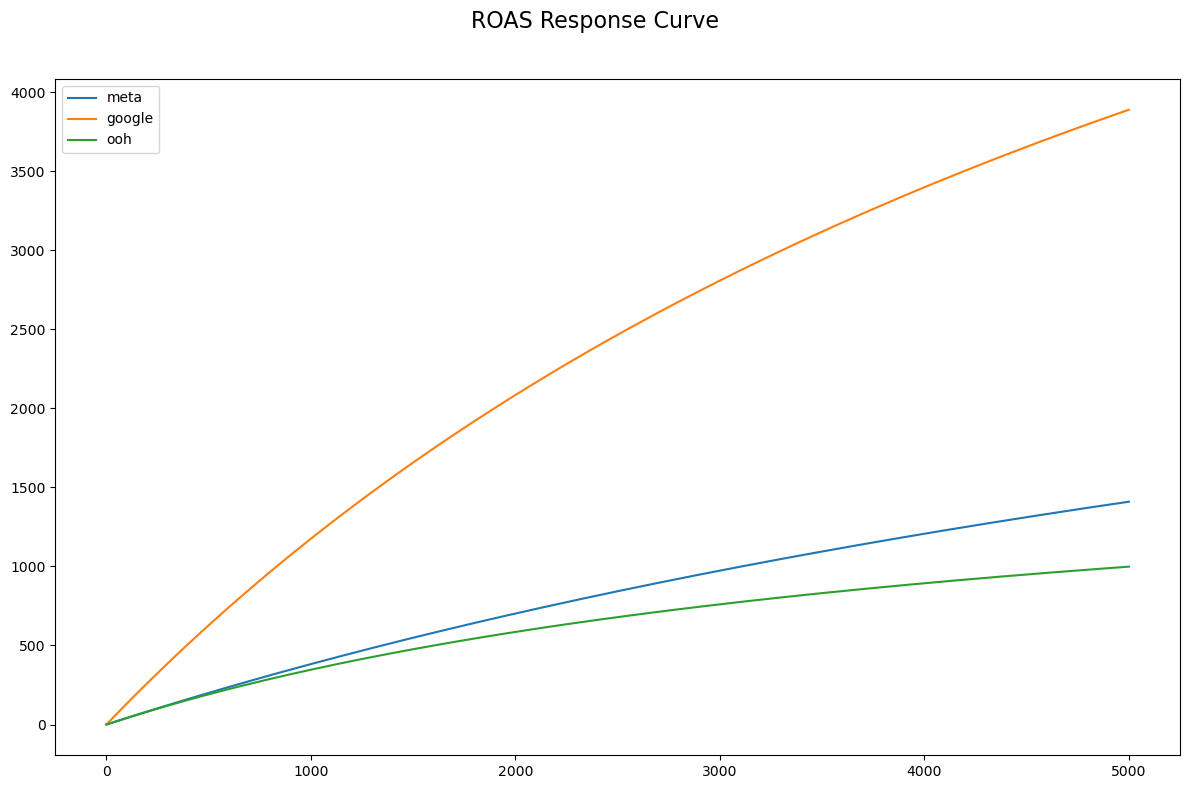

In [29]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, 8),
)
    
x = np.linspace(0, 5000, 10000)

for i, channel in enumerate(menten_params.keys()):
    y = michaelis_menten(
        x = x, 
        alpha = menten_params_modified_ltv[channel][0],
        lam = menten_params_modified_ltv[channel][1]
    )

    ax.plot(x, y, color=f"C{i}", linestyle='-', label=channel)

fig.suptitle("ROAS Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the layout to make room for the suptitle
plt.legend()
plt.show()  

In [30]:
initial_contribution = calculate_expected_contribution(
    method='michaelis-menten',
    parameters = menten_params_modified_ltv,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict,
}

pd.DataFrame(initial_scenario)

,initial_contribution,initial_budget
meta,1409.620586,5000.0
google,3889.031665,5000.0
ooh,998.769554,5000.0
total,6297.421805,NaN


In [31]:
result_menten = budget_allocator(
            method='michaelis-menten',
            total_budget=total_budget,
            channels=channels,
            parameters=menten_params_modified_ltv,
            budget_ranges=budget_bounds,
        )

result_menten

,estimated_contribution,optimal_budget
meta,1125.709965,3635.069325
google,5410.910119,9751.390215
ooh,502.866123,1613.540460
total,7039.486207,15000.000000


# Use Case 3: Marginal budget allocation

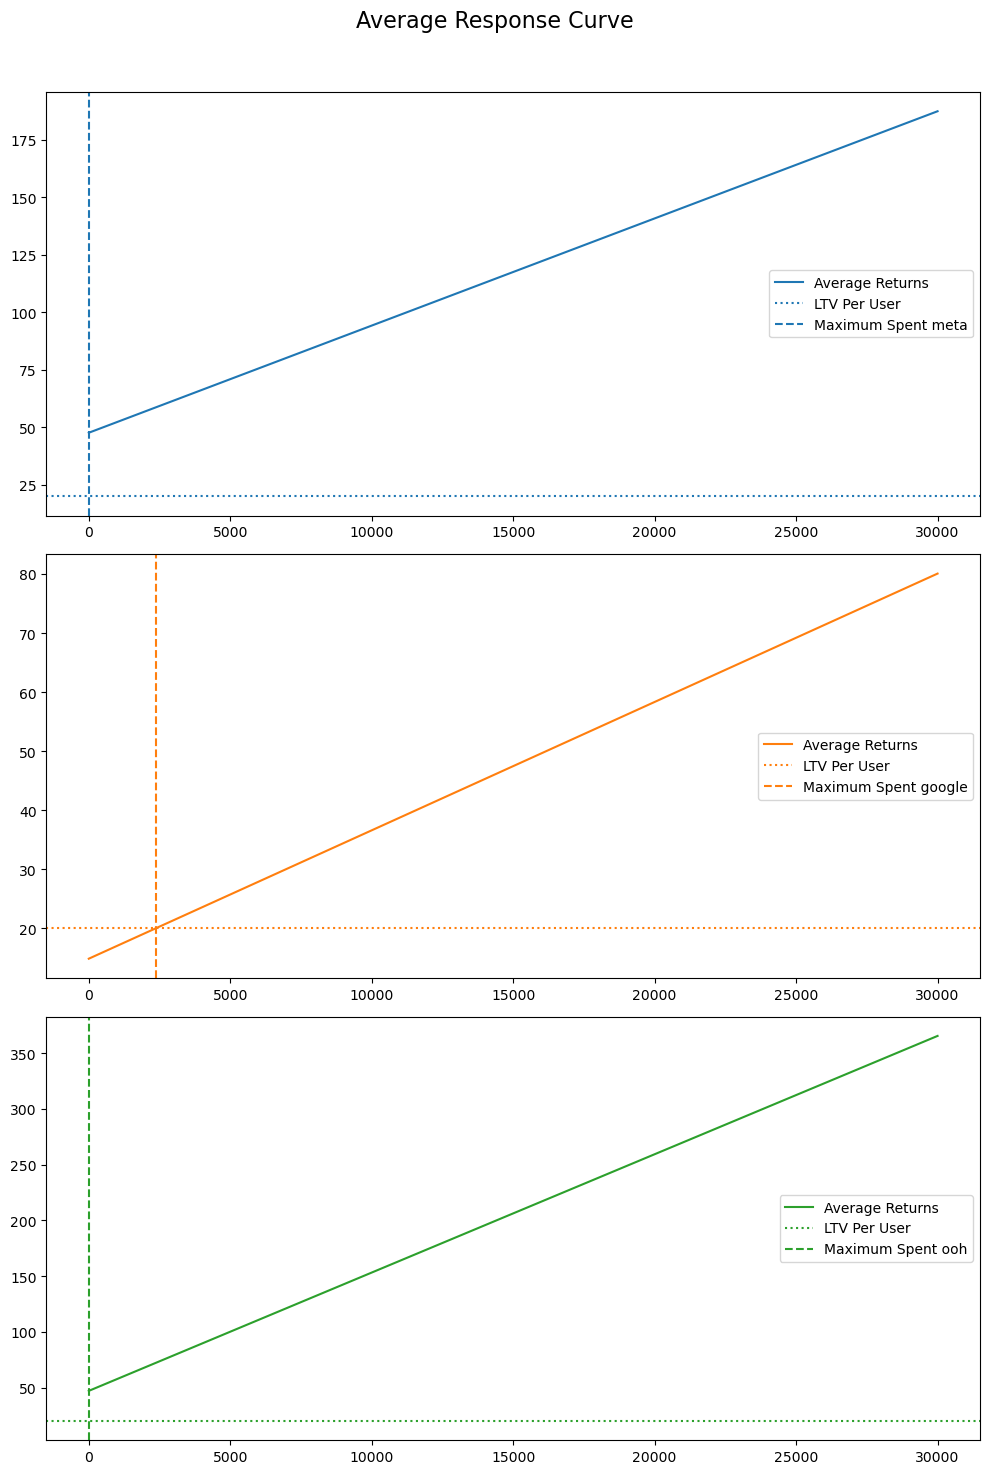

In [32]:
fig, axs = plt.subplots(
    nrows=len(menten_params.keys()),
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(10, 15),
)

x = np.linspace(0, 30000, 100000)

for i, channel in enumerate(menten_params.keys()):
    ax = axs[i]
    y = michaelis_menten(
        x = x, 
        alpha = menten_params_modified[channel][0],
        lam = menten_params_modified[channel][1]
    )
    
    _df = pd.DataFrame({
    "x":x,
    "y":y
    })
    
    _df["Average CAC"] = _df.x / _df.y 
    
    _df["Total LTV"] = _df.y * avg_ltv_per_user

    for index, row in _df.iterrows():
        if row['Average CAC'] > avg_ltv_per_user:
            first_point = row['x']
            break
        else:
            first_point = 0

    ax.plot(_df.x, 
            _df["Average CAC"],
            label='Average Returns',
            color=f"C{i}"
           )
    
    ax.axhline(avg_ltv_per_user, linestyle=':', color=f"C{i}", label='LTV Per User')
    ax.axvline(first_point, linestyle='--', color=f"C{i}", label=f'Maximum Spent {channel}')
    ax.legend()

fig.suptitle("Average Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the layout to make room for the suptitle
plt.show()

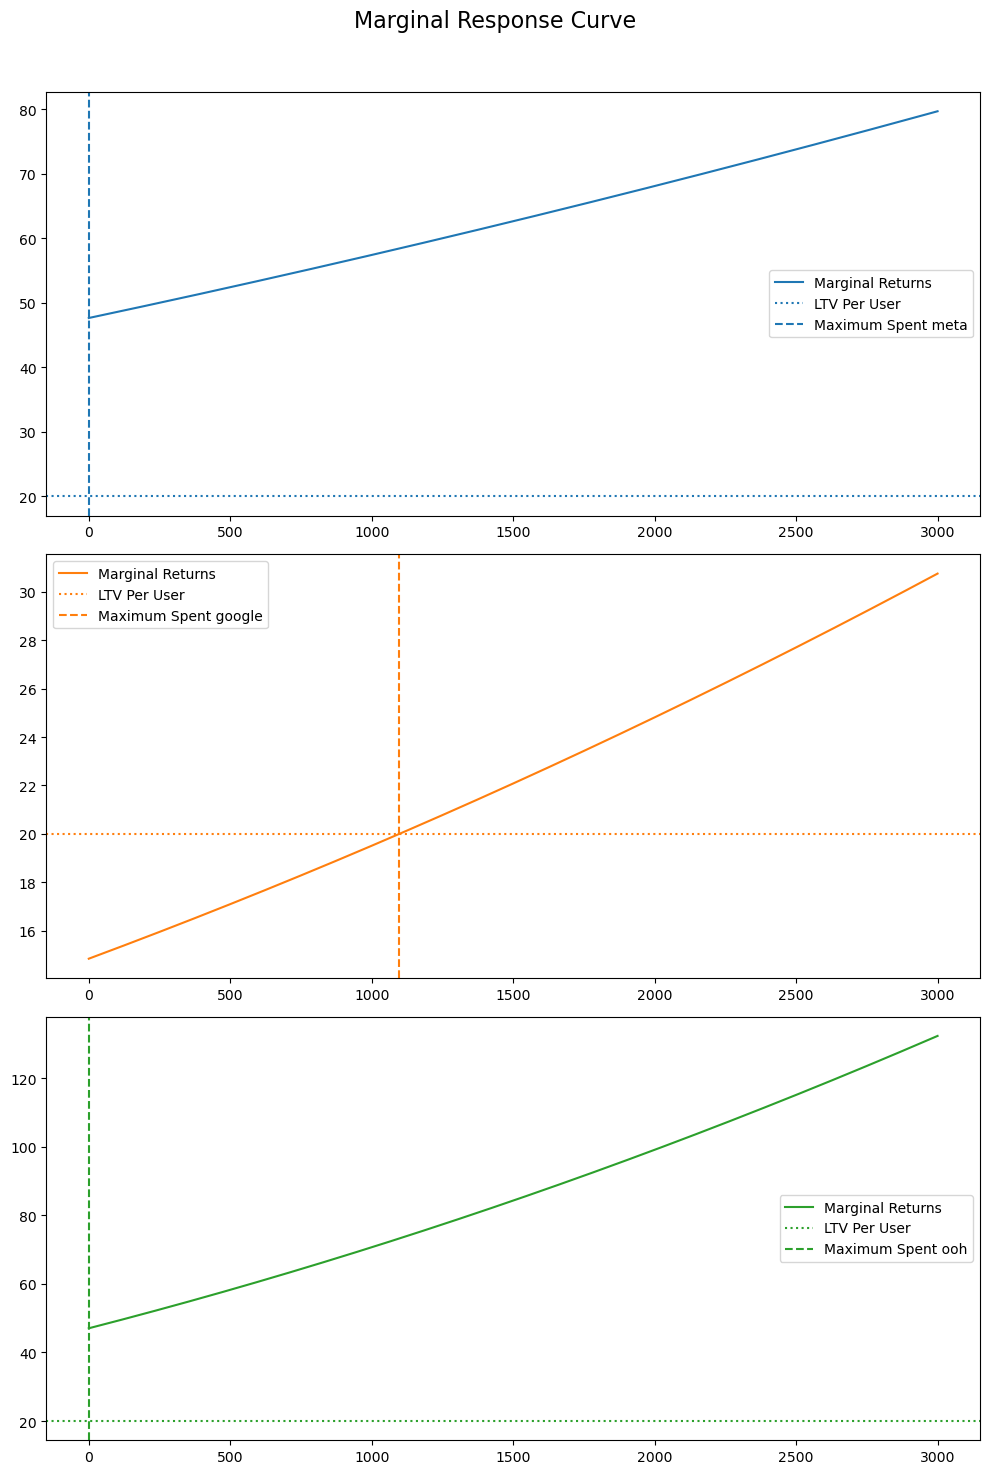

In [33]:
fig, axs = plt.subplots(
    nrows=len(menten_params.keys()),
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(10, 15),
)

x = np.linspace(0, 3000, 100000)

for i, channel in enumerate(menten_params.keys()):
    ax = axs[i]
    y = michaelis_menten(
        x = x, 
        alpha = menten_params_modified[channel][0],
        lam = menten_params_modified[channel][1]
    )
    
    _df = pd.DataFrame({
    "x":x,
    "y":y
    })
    
#     _df["Average CAC"] = _df.x / _df.y 
    _df["Marginal CAC"] = (_df.x - _df.x.shift(1)) / (_df.y - _df.y.shift(1))
    
    _df["Total LTV"] = _df.y * avg_ltv_per_user
    _df["Extra LTV"] = _df["Total LTV"] - _df["Total LTV"].shift(1)

    for index, row in _df.iterrows():
        if row['Marginal CAC'] > avg_ltv_per_user:
            first_point = row['x']
            break
        else:
            first_point = 0

    ax.plot(_df.x, 
            _df["Marginal CAC"],
            label='Marginal Returns',
            color=f"C{i}"
           )
    
    ax.axhline(avg_ltv_per_user, linestyle=':', color=f"C{i}", label='LTV Per User')
    ax.axvline(first_point, linestyle='--', color=f"C{i}", label=f'Maximum Spent {channel}')
    ax.legend()

fig.suptitle("Marginal Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the layout to make room for the suptitle
plt.show()

In [34]:
budget_bounds =  {
  'meta': [200, 200],
  'google': [200, 1100],
  'ooh': [0, 200],
}

result_menten = budget_allocator(
            method='michaelis-menten',
            total_budget=total_budget,
            channels=channels,
            parameters=menten_params_modified_ltv,
            budget_ranges=budget_bounds,
        )

result_menten

,estimated_contribution,optimal_budget
meta,82.337037,200.0
google,1276.526334,1100.0
ooh,81.353526,200.0
total,1440.216897,1500.0


# Upcoming releases
- [Out of Sample predictions](https://github.com/pymc-labs/pymc-marketing/pull/444)
- [Time Varying Coefficients](https://github.com/pymc-labs/pymc-marketing/pull/415)
- [Hierarchical Models](https://github.com/pymc-labs/pymc-marketing/pull/460)

*Notebook by Carlos Trujillo ([@cetagostini](https://github.com/cetagostini))*